# <center> **Data analysis**

<font size=4>
    
The purpose of this notebook is to understand the data handling in the code of Tian Xie and Jeffrey C. Grossman found in the following repository https://github.com/txie-93/cgcnn. That code is based on their article of [Crystal Graph Convolutional Neural Networks for an Accurate and Interpretable Prediction of Material Properties](https://arxiv.org/pdf/1710.10324.pdf) 
    
This notebook is focused on the treatment of the cif files of crystals that can be found in [Crystallography Open Database](http://www.crystallography.net/cod/) ( An open-access collection of crystal structures of organic, inorganic, metal-organic compounds and minerals ) to generate the graphs that will be passed as input to the model. 


##  Data Loading 

<font size=4>

we import the python libraries needed to process the data.


In [1]:
import csv #Read csv files
import numpy as np 
import torch #Pytorch library to convert the numpy arrays to tensors
from pymatgen.core.structure import Structure #Pymatgen (Python Materials Genomics) is a robust, 
#open-source Python library for materials analysis.

<font size=4>

From Pymatgen we can generate an object called structure that will be the crystalline system, in this case we are using the cif file of sodium chloride.

In [2]:
crystal = Structure.from_file('Media/prueba.cif')

<font size=4>

Let's take a look at the properties of the crystal structure

In [3]:
crystal

Structure Summary
Lattice
    abc : 5.62 5.62 5.62
 angles : 90.0 90.0 90.0
 volume : 177.50432800000002
      A : 5.62 0.0 3.4412575056040625e-16
      B : -3.4412575056040625e-16 5.62 3.4412575056040625e-16
      C : 0.0 0.0 5.62
PeriodicSite: Na+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Na+ (-0.0000, 2.8100, 2.8100) [0.0000, 0.5000, 0.5000]
PeriodicSite: Na+ (2.8100, 0.0000, 2.8100) [0.5000, 0.0000, 0.5000]
PeriodicSite: Na+ (2.8100, 2.8100, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Cl- (2.8100, 2.8100, 2.8100) [0.5000, 0.5000, 0.5000]
PeriodicSite: Cl- (2.8100, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
PeriodicSite: Cl- (-0.0000, 2.8100, 0.0000) [0.0000, 0.5000, 0.0000]
PeriodicSite: Cl- (0.0000, 0.0000, 2.8100) [0.0000, 0.0000, 0.5000]

<font size=4>

As we can see, it displays the cell information, with the abc lattice parameters , the volume of the unit cell and the periodic sites of the 4 sodium atoms and 4 chlorine atoms that form the unit cell.
    
To visualize the crystal we will use a package called Atomic Simulation Environment (ASE) which is similar to Pymatgen.

In [4]:
from pymatgen.io.ase import AseAtomsAdaptor
Converter = AseAtomsAdaptor()

In [5]:
ase_crystal=Converter.get_atoms(crystal)

In [6]:
#TThe following code is only for configuring the display style 
from ase.visualize import view 
view(ase_crystal, viewer='ngl')

<font size=4>
    
The unit cell of  NaCl  consists of  Na+  ions and  Cl−  ions. There are four types of site: unique central position, face site, edge sites and corner site, which are used to determine the number of Na+ ions and Cl- ions in the unit cell of NaCl. When counting the number of ions, a corner site would be shared by 7 other unit cells. Therefore, 1 corner would be 1/8 of an ion. A similar occurrence happens with the face site and the edge sites. For a face site, it is shared by 1 other unit cell and for an edge site, the ion is shared by 3 other unit cells. 

Na+
$$1_{center} + 12_{edge} \times \dfrac{1}{4} = 4\, \text{sodium ions total per cell} $$
    
Cl−
$$4_{face} \times \dfrac{1}{2} + 8_{corner} \times \dfrac{1}{8} = 4\, \text{chloride ions total per cell} $$
    
Therefore, the unit cell has 4 Na+ ions and 4 Cl− ions.
    
Each ion in this lattice has six of the other kind of ion as its nearest neighbors, and twelve of the same kind of ions as its second nearest neighbors. 
    
What we will do next is to get the nearest neighbors of the 8 atoms we saw in the unit cell, but for this since pymatgen only indexes the atoms according to their site within the unit cell and we want to identify each atom by itself then we will have to index them. 
    
First we index the 8 atoms

In [7]:
#We extract the information of the 8 atoms from the crystal 
sites=crystal.sites

In [8]:
print('The 8 atoms in the unit cell are:')
sites

The 8 atoms in the unit cell are:


[PeriodicSite: Na+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
 PeriodicSite: Na+ (-0.0000, 2.8100, 2.8100) [0.0000, 0.5000, 0.5000],
 PeriodicSite: Na+ (2.8100, 0.0000, 2.8100) [0.5000, 0.0000, 0.5000],
 PeriodicSite: Na+ (2.8100, 2.8100, 0.0000) [0.5000, 0.5000, 0.0000],
 PeriodicSite: Cl- (2.8100, 2.8100, 2.8100) [0.5000, 0.5000, 0.5000],
 PeriodicSite: Cl- (2.8100, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000],
 PeriodicSite: Cl- (-0.0000, 2.8100, 0.0000) [0.0000, 0.5000, 0.0000],
 PeriodicSite: Cl- (0.0000, 0.0000, 2.8100) [0.0000, 0.0000, 0.5000]]

In [9]:
#We create a dictionary where we are going to store the atom and the corresponding index
atoms_index={}
#For loop to get the information of each atom
i=0
for site in crystal.sites:
    atoms_index[site]=i
    i=i+1

In [10]:
atoms_index

{PeriodicSite: Na+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]: 0,
 PeriodicSite: Na+ (-0.0000, 2.8100, 2.8100) [0.0000, 0.5000, 0.5000]: 1,
 PeriodicSite: Na+ (2.8100, 0.0000, 2.8100) [0.5000, 0.0000, 0.5000]: 2,
 PeriodicSite: Na+ (2.8100, 2.8100, 0.0000) [0.5000, 0.5000, 0.0000]: 3,
 PeriodicSite: Cl- (2.8100, 2.8100, 2.8100) [0.5000, 0.5000, 0.5000]: 4,
 PeriodicSite: Cl- (2.8100, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]: 5,
 PeriodicSite: Cl- (-0.0000, 2.8100, 0.0000) [0.0000, 0.5000, 0.0000]: 6,
 PeriodicSite: Cl- (0.0000, 0.0000, 2.8100) [0.0000, 0.0000, 0.5000]: 7}

<font size=4> 
   
Attention: Do not confuse between the indices of the atom site within the unit cell and the indices that we will give them, it is true that for the 8 atoms they coincide but in principle they are not the same.
    
From now on we will refer to the atom site index with respect to the unit cell as the atom site, and to the index we gave it simply as the atom index.

<font size=4>
    
Now with a pymatgen function we will calculate the nearest neighbors of each atom in a radius of r Angstrom.

radio corte, antes de hablar de vecinos

In [11]:
#We set the radius (Angstrom)
r=3
all_nbrs = crystal.get_all_neighbors(r)

In [12]:
print('The nearest neighbors of the Na with atom site 0 and atom index 0 are:')
neighbors_from_atom_0=all_nbrs[0]
neighbors_from_atom_0

The nearest neighbors of the Na with atom site 0 and atom index 0 are:


[PeriodicSite: Cl- (-2.8100, 0.0000, -0.0000) [-0.5000, 0.0000, 0.0000],
 PeriodicSite: Cl- (0.0000, -2.8100, -0.0000) [0.0000, -0.5000, 0.0000],
 PeriodicSite: Cl- (0.0000, 0.0000, -2.8100) [0.0000, 0.0000, -0.5000],
 PeriodicSite: Cl- (0.0000, 0.0000, 2.8100) [0.0000, 0.0000, 0.5000],
 PeriodicSite: Cl- (-0.0000, 2.8100, 0.0000) [0.0000, 0.5000, 0.0000],
 PeriodicSite: Cl- (2.8100, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]]

<font size=4> 
    
Attention! The pymatgen function to obtain the neighbors what it does is to take a sphere of the radius that we want and then the atoms that fall in that sphere it takes them as near neighbors. This method preserves the symmetry of the crystal. For the first nearest neighbors (radius of 3 Angstroms) are 6 atoms and for the second nearest neighbors are 18 (radius of 4 Angstroms). But in the code they use only the first 12 nearest neighbors, breaking this symmetry. That is why from the beginning we put in how many maximum nearest neighbors we want to consider.

<font size=4>

Now we want to index those neighbors and add them to the dictionary

In [13]:
#Each neighbor of the atom with atom index 0
for neighbor in neighbors_from_atom_0:
    #Check if the neighbor is already in the dictionary
    if neighbor not in atoms_index.keys():
        #Add the index to the new neighbor
        atoms_index[neighbor]=max(atoms_index.values())+1

In [14]:
atoms_index

{PeriodicSite: Na+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]: 0,
 PeriodicSite: Na+ (-0.0000, 2.8100, 2.8100) [0.0000, 0.5000, 0.5000]: 1,
 PeriodicSite: Na+ (2.8100, 0.0000, 2.8100) [0.5000, 0.0000, 0.5000]: 2,
 PeriodicSite: Na+ (2.8100, 2.8100, 0.0000) [0.5000, 0.5000, 0.0000]: 3,
 PeriodicSite: Cl- (2.8100, 2.8100, 2.8100) [0.5000, 0.5000, 0.5000]: 4,
 PeriodicSite: Cl- (2.8100, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]: 5,
 PeriodicSite: Cl- (-0.0000, 2.8100, 0.0000) [0.0000, 0.5000, 0.0000]: 6,
 PeriodicSite: Cl- (0.0000, 0.0000, 2.8100) [0.0000, 0.0000, 0.5000]: 7,
 PeriodicSite: Cl- (-2.8100, 0.0000, -0.0000) [-0.5000, 0.0000, 0.0000]: 8,
 PeriodicSite: Cl- (0.0000, -2.8100, -0.0000) [0.0000, -0.5000, 0.0000]: 9,
 PeriodicSite: Cl- (0.0000, 0.0000, -2.8100) [0.0000, 0.0000, -0.5000]: 10}

<font size=4>
    
Let us do the same for the other atoms. 

In [15]:
#list of neighbors of each atom in the unit cell
for neighbors in all_nbrs:
    #neighbor of the list of neighbors
    for neighbor in neighbors:
        #Check if the neighbor is already in the dictionary
        if neighbor not in atoms_index.keys():
            #Add the index to the new neighbor
            atoms_index[neighbor]=max(atoms_index.values())+1

In [16]:
atoms_index

{PeriodicSite: Na+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]: 0,
 PeriodicSite: Na+ (-0.0000, 2.8100, 2.8100) [0.0000, 0.5000, 0.5000]: 1,
 PeriodicSite: Na+ (2.8100, 0.0000, 2.8100) [0.5000, 0.0000, 0.5000]: 2,
 PeriodicSite: Na+ (2.8100, 2.8100, 0.0000) [0.5000, 0.5000, 0.0000]: 3,
 PeriodicSite: Cl- (2.8100, 2.8100, 2.8100) [0.5000, 0.5000, 0.5000]: 4,
 PeriodicSite: Cl- (2.8100, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]: 5,
 PeriodicSite: Cl- (-0.0000, 2.8100, 0.0000) [0.0000, 0.5000, 0.0000]: 6,
 PeriodicSite: Cl- (0.0000, 0.0000, 2.8100) [0.0000, 0.0000, 0.5000]: 7,
 PeriodicSite: Cl- (-2.8100, 0.0000, -0.0000) [-0.5000, 0.0000, 0.0000]: 8,
 PeriodicSite: Cl- (0.0000, -2.8100, -0.0000) [0.0000, -0.5000, 0.0000]: 9,
 PeriodicSite: Cl- (0.0000, 0.0000, -2.8100) [0.0000, 0.0000, -0.5000]: 10,
 PeriodicSite: Cl- (-2.8100, 2.8100, 2.8100) [-0.5000, 0.5000, 0.5000]: 11,
 PeriodicSite: Cl- (-0.0000, 2.8100, 5.6200) [0.0000, 0.5000, 1.0000]: 12,
 PeriodicSite: Cl- (-0.0000, 5.6200

In [17]:
print('The total number of atoms to be considered, taking the cutoff radius of',r,'Angstroms is',len(atoms_index))

The total number of atoms to be considered, taking the cutoff radius of 3 Angstroms is 32


<font size=4>
    
Now to build the network we will use the networkx library

In [18]:
import networkx as nx

In [19]:
#Build the graph
G = nx.Graph()

In [20]:
#Add the nodes, since each node represents an atom we will have len(atoms_index) nodes
G.add_nodes_from(list(range(len(atoms_index))))

In [21]:
print('The nodes are \n',G.nodes,'\n')
print('The number of nodes in the graph is \n',len(G.nodes))

The nodes are 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 

The number of nodes in the graph is 
 32


In [22]:
#Loop for all the nodes in the graph
for atom in G.nodes:
    #Since we want to bond the neighbors of the 8 atoms in the unit cell then the other atoms
    #will have no bonds between them.
    if atom<8:
        #Take the neighbors of the atom
        for neighbor in all_nbrs[atom]:
            #Add the edge between the atom and its neighbor
            G.add_edge(atom,atoms_index.get(neighbor))

añadir la otra explicación

In [23]:
print('The edges are \n',G.edges,'\n')
print('The number of edges in the graph is \n',len(G.edges))

The edges are 
 [(0, 8), (0, 9), (0, 10), (0, 7), (0, 6), (0, 5), (1, 11), (1, 7), (1, 6), (1, 4), (1, 12), (1, 13), (2, 14), (2, 7), (2, 5), (2, 4), (2, 15), (2, 16), (3, 17), (3, 6), (3, 5), (3, 4), (3, 18), (3, 19), (4, 20), (4, 21), (4, 22), (5, 23), (5, 24), (5, 25), (6, 26), (6, 27), (6, 28), (7, 29), (7, 30), (7, 31)] 

The number of edges in the graph is 
 36


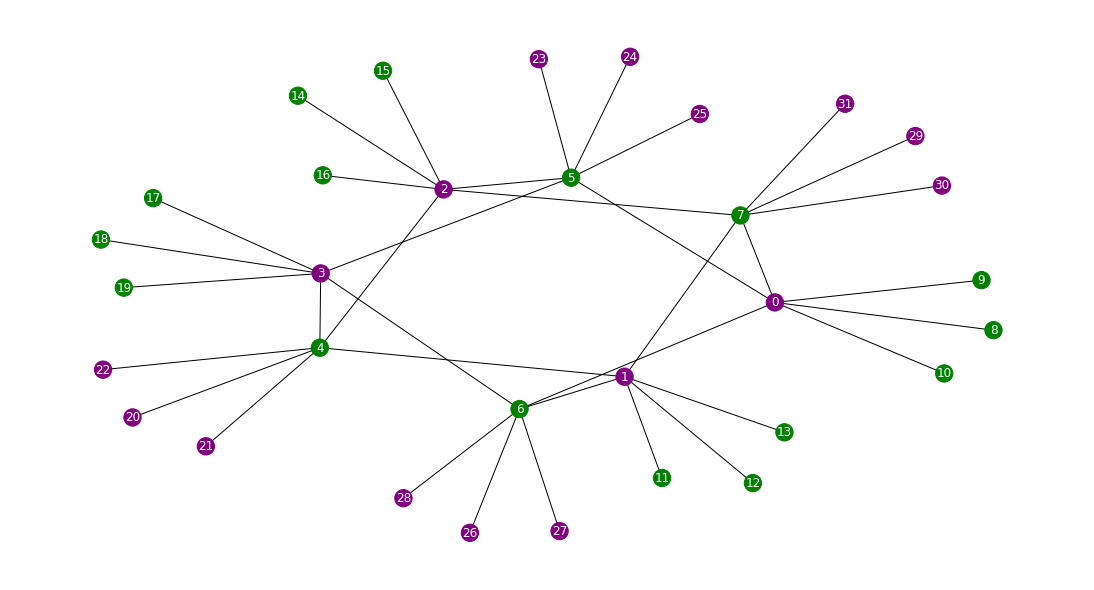

In [24]:
#This part is only to visualize the network so it is not relevant to see the commands
#step by step.

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(15, 8))

color_map=[] #List of the nodes color
atoms_list = list(atoms_index.keys())
for node in G.nodes:
    atom=atoms_list[node]
    if atom.specie.number==11: #If the atom is Sodium
        color_map.append('purple')
    else: #If the atom is Chlorine
        color_map.append('green')
#pos = nx.bipartite_layout(G,(0,1,2,3,4,5,6,7),align='vertical')
pos=nx.spring_layout(G,seed=14)
nx.draw(G, pos=pos, node_color=color_map, with_labels=True,font_color="white")
plt.show()

<font size=4> 
    
This way of representing the 8 atoms with their respective neighbors with a graph is different from what they do in the code. To explain how the graph is created in the code we must understand that in their graph instead of the nodes representing atoms, the nodes represent sites within the unit cell, remember that we have 8 sites for all the atoms of the crystal so we will have only 8 nodes. Now between two pairs of nodes it is possible that there are several edges since two sites can be linked multiple times. 
    
To make the construction of the graph easier, we will first occupy the previous graph and instead of putting the atom index we will put the site index

In [25]:
for atom_idx in G.nodes(): #Loop over the atoms/nodes
    if atom_idx>7:
        atom=atoms_list[atom_idx]
        G.nodes[atom_idx]['index_site'] = atom.index #Add the atom site as an attribute
    else:
        G.nodes[atom_idx]['index_site'] = atom_idx   #The atom site and the atom index 
        #of the 8 atoms match

In [26]:
print('The atom site of each atom is',nx.get_node_attributes(G,'index_site'))

The atom site of each atom is {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 5, 9: 6, 10: 7, 11: 4, 12: 6, 13: 7, 14: 4, 15: 5, 16: 7, 17: 4, 18: 5, 19: 6, 20: 3, 21: 2, 22: 1, 23: 3, 24: 2, 25: 0, 26: 3, 27: 1, 28: 0, 29: 2, 30: 1, 31: 0}


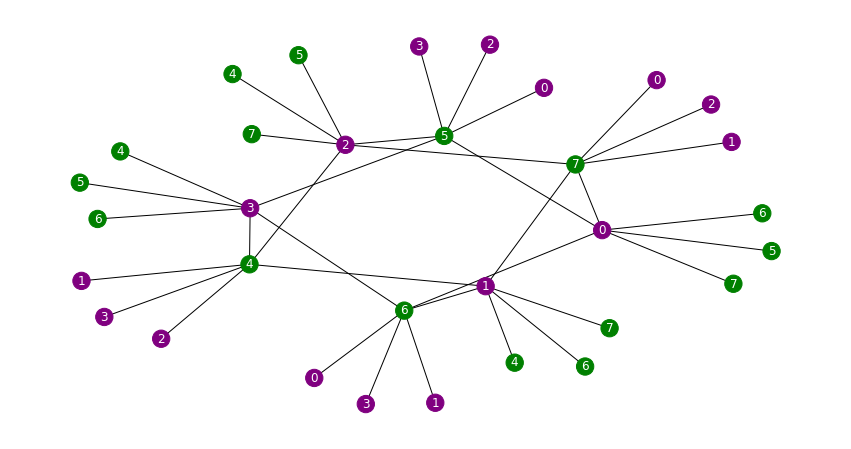

In [27]:
figure(figsize=(15, 8))
node_labels = nx.get_node_attributes(G, 'index_site')
nx.draw_networkx_labels(G, pos, labels=node_labels,font_color="white")
nx.draw(G, pos=pos, node_color=color_map)
plt.show()

<font size=4> 

Now as each node is a site, then each union between two sites is represented by an edge.

In [28]:
G_code=nx.MultiGraph()
G_code.add_nodes_from(list(range(8)))
G_code.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7))

In [29]:
for atom_site_idx in G_code.nodes:
    for neighbor in all_nbrs[atom_site_idx]:
        if atom_site_idx<neighbor.index:
            G_code.add_edge(atom_site_idx,neighbor.index)

In [30]:
print('The edges are \n',G_code.edges,'\n')
print('The number of edges in the graph is \n',len(G_code.edges))

The edges are 
 [(0, 5, 0), (0, 5, 1), (0, 6, 0), (0, 6, 1), (0, 7, 0), (0, 7, 1), (1, 4, 0), (1, 4, 1), (1, 7, 0), (1, 7, 1), (1, 6, 0), (1, 6, 1), (2, 4, 0), (2, 4, 1), (2, 7, 0), (2, 7, 1), (2, 5, 0), (2, 5, 1), (3, 4, 0), (3, 4, 1), (3, 6, 0), (3, 6, 1), (3, 5, 0), (3, 5, 1)] 

The number of edges in the graph is 
 24


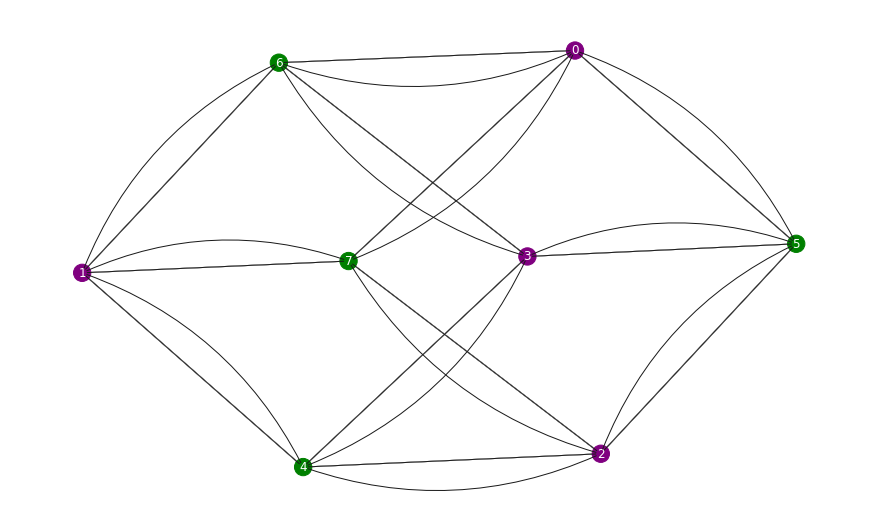

In [31]:
figure(figsize=(12, 7))
color_map=[]
atoms_list = list(atoms_index.keys())
for node in G_code.nodes:
    atom=atoms_list[node]
    if atom.specie.number==11:
        color_map.append('purple')
    else:
        color_map.append('green')
pos = nx.spring_layout(G_code,seed=1)

nx.draw(G_code, pos=pos,node_color=color_map, with_labels=True,font_color="white")
nx.draw_networkx_edges(G_code, pos, edge_color='white')
ax = plt.gca()
for e in G_code.edges:
    ax.annotate("", xy=pos[e[0]], xycoords='data',xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-", color=".1",shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.2*e[2])),),)
plt.axis('off')
plt.show()

<font size=4>  
    
Now what is going to be passed as input to the model?    
    

Note that the adjacency matrix does not consider multiple edges, which we do need given our graph. That is why in the code they define the matrix called nbr_idx, a matrix where the first row represents the atom site 0 and the row values are the atom sites to which it is connected. Thus the second row represents the atom site 1 and so on.

In [32]:
#Declare the matrix
nbr_idx=[]
#Loop over neighbors of each atom
for nbrs in all_nbrs:
    #Add the atom site of each neighbor of the atom
    nbr_idx.append(list(map(lambda x: x[2],nbrs)))

In [33]:
nbr_idx

[[5, 6, 7, 7, 6, 5],
 [4, 7, 6, 4, 6, 7],
 [4, 7, 5, 4, 5, 7],
 [4, 6, 5, 4, 5, 6],
 [3, 2, 1, 3, 2, 1],
 [3, 2, 3, 2, 0, 0],
 [3, 1, 3, 1, 0, 0],
 [2, 1, 2, 1, 0, 0]]

In [34]:
print('The atom site 0 is connected to the atoms sites:',nbr_idx[0])

The atom site 0 is connected to the atoms sites: [5, 6, 7, 7, 6, 5]


<font size=4>  
    
In addition to the matrix that indicates the connections of the graph, they define another matrix where the distances that each neighbor has will be added. 

In [35]:
#Declare the matrix
nbr_dist=[]
##Loop over neighbors of each atom
for nbrs in all_nbrs:
    #Add the distance of each neigbor of the atom
    nbr_dist.append(list(map(lambda x: x[1],nbrs)))

In [36]:
nbr_dist

[[2.81, 2.81, 2.81, 2.81, 2.81, 2.81],
 [2.81, 2.81, 2.81, 2.81, 2.81, 2.81],
 [2.81, 2.81, 2.81, 2.81, 2.81, 2.81],
 [2.81, 2.81, 2.81, 2.81, 2.81, 2.81],
 [2.81, 2.81, 2.81, 2.8099999999999996, 2.81, 2.81],
 [2.81, 2.8100000000000005, 2.81, 2.8099999999999996, 2.81, 2.81],
 [2.81, 2.8100000000000005, 2.81, 2.8099999999999996, 2.81, 2.81],
 [2.81, 2.81, 2.81, 2.81, 2.81, 2.81]]

In [37]:
print('The atom site 0 is connected to the atom site',nbr_idx[0][0],'with a distance of',nbr_dist[0][0])

The atom site 0 is connected to the atom site 5 with a distance of 2.81


<font size=4>  
    
Finally, to give attributes to the nodes, a list is created where each index corresponds to the atomic number of the site of the atom of the corresponding index. (These attributes are provisional to exemplify the model, but the next notebook will show the real attributes, atom feature vectors and distance feature vectors, that will be passed to the network)

In [38]:
atom_fea = np.vstack([crystal[i].specie.number for i in range(len(crystal))])

poner otros atributos. llamar matriz al de caracteristicas

In [39]:
atom_fea

array([[11],
       [11],
       [11],
       [11],
       [17],
       [17],
       [17],
       [17]])

In [40]:
print('The atom site 0 has an atomic number of',atom_fea[0])

The atom site 0 has an atomic number of [11]


<font size=4>  
    
The attribute of both the atoms and the connections between them will be added to the graph that we have already defined for better visualization.

In [41]:
#Loop over the nodes/atoms of the graph
for node in G_code:
    #Add the attribute 'atomic_number' to each node/atom
    G_code.nodes[node]['atomic number'] = atom_fea[node]

#Loop over the edges of the graph
for edge in G_code.edges:
    atom=edge[0] #Atom index
    nbr=edge[1]  #Neighbor index
    multiplicity=edge[2] #Number of connections to that neighbor
    
    #Add the attribute 'distance' to each edge
    G_code[atom][nbr][multiplicity]['distance']=nbr_dist[atom][[i for i, n 
                                                                in enumerate(nbr_idx[atom])
                                                                if n == nbr][multiplicity]]

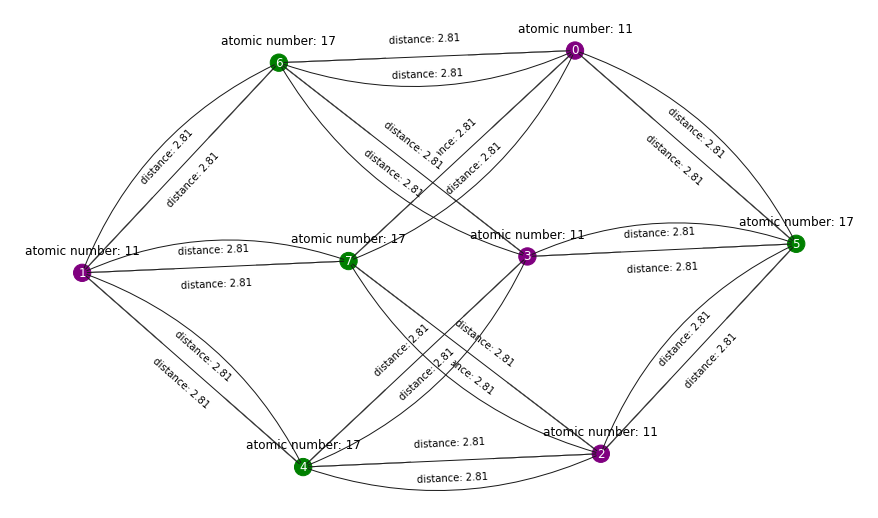

In [42]:
#This code is just for r=3 due to visualiations reasons
figure(figsize=(12, 7))
pos = nx.spring_layout(G_code,seed=1)
nx.draw(G_code, pos=pos,node_color=color_map, with_labels=True,font_color="white")
nx.draw_networkx_edges(G_code, pos, edge_color='white')
ax = plt.gca()
for e in G_code.edges:
    draw_multiple_edges=ax.annotate("", xy=pos[e[0]], xycoords='data',xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-", color=".1",shrinkA=5, shrinkB=5,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.2*e[2])),),)

pos_attrs = {}
for node, coords in pos.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
node_attrs = nx.get_node_attributes(G_code, 'atomic number')
custom_node_attrs = {}

for node, attr in node_attrs.items():
    custom_node_attrs[node] = 'atomic number: '+str(attr[0])
nx.draw_networkx_labels(G, pos_attrs, labels=custom_node_attrs)

edge_labels=nx.get_edge_attributes(G_code,'distance')
for u,v,w in edge_labels:
    nx.draw_networkx_edge_labels(G_code, pos, {(u,v):'distance: '+str(edge_labels[(u,v,w)])
                                               +' \n \n \n''distance: '
                                               +str(edge_labels[(u,v,w)])})
plt.axis('off')
plt.show()

<font size=4>  

**Batch**

<font size=4>  
    
For the creation of batches the function collate_pool is defined, where as a parameter it receives a list of crystals.
    
Since the batch contains information from many crystals, the atoms will be indexed according to their crystal so that they can be identified later. 
    
From now on we will call atoms the atoms sites.    
    
To explain the latter in a better way, let's suppose that in the batch there are two crystals, crystal_1 and crystal_2 with 2 and 3 atoms respectively.
    
From the above we know that the atoms of each crystal will be indexed from 0 to the number of atoms in that cristal-1, so if A and B are the atoms of crystal_1 and C,D,E those of crystal_2, the indices will be
    
$$A \longrightarrow 0 \\
B \longrightarrow 1 \\
C \longrightarrow 0\\
D \longrightarrow 1\\
E \longrightarrow 2$$
    
So how can we distinguish between atoms A and C, B and D?
    
For this we add an index associated to their crystal. Let's define base_idx=0, now we index the atoms of the crystal_1 as usual 
$$A \longrightarrow 0 \\
B \longrightarrow 1 $$

and then we update base_idx as base_idx=base_idx+numer_of_atoms_in_previous_crystal=0+2=2

Now to index the atoms of the next crystal we index in the usual way and add the base_idx
    
$$C \longrightarrow 0+2=2\\
D \longrightarrow 1+2=3\\
E \longrightarrow 2+2=4$$
    
We can then uniquely identify all the atoms within the batch.
    
This mapping between the crystal and its atoms will be used later for the pooling layers.

In [43]:
def collate_pool(dataset_list):
    """
    Collate a list of data and return a batch for predicting crystal
    properties.

    Parameters
    ----------

    dataset_list: list of tuples for each data point.
      (atom_fea, nbr_fea, nbr_fea_idx, target)

      atom_fea: torch.Tensor shape (n_i, atom_fea_len)
      nbr_fea: torch.Tensor shape (n_i, M, nbr_fea_len)
      nbr_fea_idx: torch.LongTensor shape (n_i, M)
      target: torch.Tensor shape (1, )
      cif_id: str or int

    Returns
    -------
    N = sum(n_i) Number of total atoms in the batch
    N0 = sum(i)  Number of crystals in the batch;

    batch_atom_fea: torch.Tensor shape (N, orig_atom_fea_len)
      Atom features from atom type
    batch_nbr_fea: torch.Tensor shape (N, M, nbr_fea_len)
      Bond features of each atom's M neighbors
    batch_nbr_fea_idx: torch.LongTensor shape (N, M)
      Indices of M neighbors of each atom
    crystal_atom_idx: list of torch.LongTensor of length N0
      Mapping from the crystal idx to atom idx
    target: torch.Tensor shape (N, 1)
      Target value for prediction
    batch_cif_ids: list
    """
    batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx = [], [], []
    crystal_atom_idx, batch_target = [], []
    batch_cif_ids = []
    
   
    base_idx = 0 #This index will allow to identify each atom within the batch
    for i, ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id)\
            in enumerate(dataset_list): #loop over the crystals 
        n_i = atom_fea.shape[0]  # number of atoms for this crystal
        batch_atom_fea.append(atom_fea) 
        batch_nbr_fea.append(nbr_fea) 
        batch_nbr_fea_idx.append(nbr_fea_idx+base_idx) #add the base index to the 
        #atom index
        new_idx = torch.LongTensor(np.arange(n_i)+base_idx) #A list is created from 0 
        #to the number of atoms in the crystal and then the base_idx is added. 
        crystal_atom_idx.append(new_idx) 
        batch_target.append(target)
        batch_cif_ids.append(cif_id)
        base_idx += n_i #The base index is updated with respect to the number of atoms 
        #in the previous crystal.
    return (torch.cat(batch_atom_fea, dim=0),
            torch.cat(batch_nbr_fea, dim=0),
            torch.cat(batch_nbr_fea_idx, dim=0),
            crystal_atom_idx),\
        torch.stack(batch_target, dim=0),\
        batch_cif_ids

# <center>**Model**

## Defining graph convolution 

<font size=4>

We import the Pytorch libraries 

In [44]:
import torch #The torch package contains data structures for multi-dimensional tensors and defines mathematical 
#operations over these tensors. 
import torch.nn as nn #	Subpackage of buiding blocks for all neural network modules.

<font size=4>

We convert the three arrays into tensors 

In [45]:

nbr_fea_idx, nbr_fea = np.array(nbr_idx), np.array(nbr_dist)   #We pass them to numpy array because if we 
#remember we defined them as lists.
atom_fea = torch.Tensor(atom_fea)
nbr_fea = torch.Tensor(nbr_fea)
nbr_fea_idx = torch.LongTensor(nbr_idx) #We use LongTensor because nbr_idx values are integers

cambiar nbr_fea a bond_fea

In [78]:
N, M = nbr_fea_idx.shape
n , m = 1,1
print('The total atoms in the crystal  is',N)
print('The maximum number of neighbors of each atom is' ,M)
print('The number of atom features is',n)
print('The number of neighbor features is' ,m)
print('The tensor shape of atom_fea is',atom_fea.shape)
print('The tensor shape of bond_fea is',nbr_fea.shape)
print('The tensor shape of nbr_fea_idx is',nbr_fea_idx.shape)

The total atoms in the crystal  is 8
The maximum number of neighbors of each atom is 6
The number of atom features is 1
The number of neighbor features is 1
The tensor shape of atom_fea is torch.Size([8, 1])
The tensor shape of bond_fea is torch.Size([8, 6])
The tensor shape of nbr_fea_idx is torch.Size([8, 6])


<font size=4>  
    
What we will do now is to concatenate the 2 tensors of attributes, according to the connections between the sites given by the nbr_fea_idx

In [47]:
#Connections between atoms sites are added.
atom_nbr_fea = atom_fea[nbr_idx, :]
atom_nbr_fea

tensor([[[17.],
         [17.],
         [17.],
         [17.],
         [17.],
         [17.]],

        [[17.],
         [17.],
         [17.],
         [17.],
         [17.],
         [17.]],

        [[17.],
         [17.],
         [17.],
         [17.],
         [17.],
         [17.]],

        [[17.],
         [17.],
         [17.],
         [17.],
         [17.],
         [17.]],

        [[11.],
         [11.],
         [11.],
         [11.],
         [11.],
         [11.]],

        [[11.],
         [11.],
         [11.],
         [11.],
         [11.],
         [11.]],

        [[11.],
         [11.],
         [11.],
         [11.],
         [11.],
         [11.]],

        [[11.],
         [11.],
         [11.],
         [11.],
         [11.],
         [11.]]])

<font size=4>  
    
Let's see what the atom_nbr_fea tensor represents

In [79]:
print('The neighbors attribute of atom 3 are \n',atom_nbr_fea[3], ' \n and the number of neighbors is',
     len(atom_nbr_fea[3]))

The neighbors attribute of atom 3 are 
 tensor([[17.],
        [17.],
        [17.],
        [17.],
        [17.],
        [17.]])  
 and the number of neighbors is 6


In [49]:
total_nbr_fea = torch.cat([atom_fea.unsqueeze(1).expand(N, M, 1),
                           atom_nbr_fea, nbr_fea.unsqueeze(2)], dim=2)
total_nbr_fea

tensor([[[11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100]],

        [[11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100]],

        [[11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100]],

        [[11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100],
         [11.0000, 17.0000,  2.8100]],

        [[17.0000, 11.0000,  2.8100],
         [17.0000, 11.0000,  2.8100],
    

añadir imagen del grafo completo

<font size=4>  
    
But what does this final tensor represent?

In [50]:
info_atom_0=total_nbr_fea[0]
print('The information of atom 0 is given by the tensor \n',info_atom_0)

The information of atom 0 is given by the tensor 
 tensor([[11.0000, 17.0000,  2.8100],
        [11.0000, 17.0000,  2.8100],
        [11.0000, 17.0000,  2.8100],
        [11.0000, 17.0000,  2.8100],
        [11.0000, 17.0000,  2.8100],
        [11.0000, 17.0000,  2.8100]])


In [51]:
print('The atom 0 has attribute',info_atom_0[0,0], ' and is connected to',len(info_atom_0),
      'atoms with the following attributes')
info_atom_0[:,1]

The atom 0 has attribute tensor(11.)  and is connected to 6 atoms with the following attributes


tensor([17., 17., 17., 17., 17., 17.])

In [52]:
print('And their correspoding distance to each atom site is ')
info_atom_0[:,2]

And their correspoding distance to each atom site is 


tensor([2.8100, 2.8100, 2.8100, 2.8100, 2.8100, 2.8100])

<font size=4>  
    
Before defining graph convolutions in Pytorch, we will see how they are defined in a visual form to make it easier to understand them.

We will update the attribute vector of atom 6.

solo poner la 1 y la 6 

<video width="700" height="400" controls src="Media/Graph_conv.mp4">animation</video>

<font size=4>
    
As you can see in the video, first the information of atom 6 is added to that of its neighbor atom 1 and to that of its connection, each one is multiplied by a weight that will be trained later $(17w_1+11w_3+2.81w_5)$. This is for one of the 6 neighbors, however as we can see the other 5 neighbors have the same information of their own attributes (all have atomic number 11) and the connection to atom 1 (all have distance 2.81), that is why we can see in the video that simply to add it is added 6 times the previous one $(17w_1+11w_3+2.81w_5)\cdot 6$.Then the same thing is done again but now with different weights (so that not all neighbors share the same weight).

Then activations functions ($f$ and $g$) are applied to both terms and finally all terms for each neighbor are added up and multiplied to remain the following term $f(17w_1+11w_3+2.81w_5)\cdot6 \cdot g(17w_2+11w_4+2.81w_6)\cdot6$


<font size=4>  
    
Now that it has been explained visually, we will proceed to build the convolution in Pytorch. For this purpose,a linear transformation is performed on the tensor, notice that the tensor has the shape:

In [53]:
total_nbr_fea.shape

torch.Size([8, 6, 3])

<font size=4> 

Which can be obtained as 

In [54]:
[N,M,2*n+m]

[8, 6, 3]

In [55]:
#Define the linear transformation
linear= nn.Linear(2*n+m, 2*n)
#Apply it to the tensor
total_gate_fea = linear(total_nbr_fea)
total_gate_fea.shape

torch.Size([8, 6, 2])

<font size=4>

When applying the linear transformation, the atom's information is being added together with its neighbor and its connection attribute, to see it more clearly let's put explicitly what is happening behind the pytorch nn.Linear function.

Letś denote the attribute of the atom 0 as $v_0$ and suppose (for simplicity) that has 6 neighbors and their corresponding attribute is $v_1,v_2,v_3,v_4,v_5,v_6$. 

In the same way let us denote its corresponding edge attribute as $u_{(0,1)},u_{(0,2)},u_{(0,3)},u_{(0,4)},u_{(0,5)},u_{(0,6)}$.
    
What the transformation does to the information of the first site atom is the following multiplication
    
$$\begin{align*}
    \begin{bmatrix}
    v_0& v_1 & u_{(0,1)} \\
    v_0& v_2 & u_{(0,2)} \\
    v_0& v_3 & u_{(0,3)} \\
    v_0& v_4 & u_{(0,4)} \\
    v_0& v_5 & u_{(0,5)} \\
    v_0& v_6 & u_{(0,6)} \\
    \end{bmatrix}
    \begin{bmatrix}
    w_1 & w_2 \\
    w_3 & w_4 \\
    w_5 & w_6 \\
    \end{bmatrix}=
    \begin{bmatrix}
    w_1 v_0+ w_3 v_1 + w_5u_{(0,1)} & w_2 v_0+ w_4 v_1 + w_6u_{(0,1)}\\
    w_1 v_0+ w_3 v_2 + w_5u_{(0,2)} & w_2 v_0+ w_4 v_2 + w_6u_{(0,2)}\\
    w_1 v_0+ w_3 v_3 + w_5u_{(0,3)} & w_2 v_0+ w_4 v_3 + w_6u_{(0,3)}\\
    w_1 v_0+ w_3 v_4 + w_5u_{(0,4)} & w_2 v_0+ w_4 v_4 + w_6u_{(0,4)}\\
    w_1 v_0+ w_3 v_5 + w_5u_{(0,5)} & w_2 v_0+ w_4 v_5 + w_6u_{(0,5)}\\
    w_1 v_0+ w_3 v_6 + w_5u_{(0,6)} & w_2 v_0+ w_4 v_6 + w_6u_{(0,6)}\\
    \end{bmatrix}
\end{align*}$$
    
We note that the first column of the matrix is the following sum: 
    
<center>
attribute of the atom * weight1 + attribute of its neighbor*weight3 + attribute of its connection * weight5 
    
    
    
    
These weights are the ones to be trained, the second column is the same but the weights are different. 
    
Subsequently, a normalization is performed

In [56]:
#Declare the BatchNorm1d function
bn1 = nn.BatchNorm1d(2*n) 
#Since the BatchNorm1d function takes 1D tensors as input, then the tensor view function is used 
#to rescale the tensor so that it is of length 2*n.
total_gate_fea = bn1(total_gate_fea.view(
            -1, 2*n))
#Finally, the tensor is returned to the original dimensions.
total_gate_fea=total_gate_fea.view(N, M, 2*n)

<font size=4>

The tensor is divided into 2

In [57]:
nbr_filter, nbr_core = total_gate_fea.chunk(2, dim=2)

<font size=4>

When applying the chunk function we do the following:
    
$$\text{total}=\begin{bmatrix}
    w_1 v_0+ w_3 v_1 + w_5u_{(0,1)} & w_2 v_0+ w_4 v_1 + w_6u_{(0,1)}\\
    w_1 v_0+ w_3 v_2 + w_5u_{(0,2)} & w_2 v_0+ w_4 v_2 + w_6u_{(0,2)}\\
    w_1 v_0+ w_3 v_3 + w_5u_{(0,3)} & w_1 v_0+ w_4 v_3 + w_6u_{(0,3)}\\
    w_1 v_0+ w_3 v_4 + w_5u_{(0,4)} & w_1 v_0+ w_4 v_4 + w_6u_{(0,4)}\\
    w_1 v_0+ w_3 v_5 + w_5u_{(0,5)} & w_1 v_0+ w_4 v_5 + w_6u_{(0,5)}\\
    w_1 v_0+ w_3 v_6 + w_5u_{(0,6)} & w_1 v_0+ w_4 v_6 + w_6u_{(0,6)}
    \end{bmatrix}\\\\\\\\ 
\text{nbr-filter}=\begin{bmatrix}
    w_2 v_0+ w_4 v_1 + w_6u_{(0,1)}\\
    w_2 v_0+ w_4 v_2 + w_6u_{(0,2)}\\
     w_1 v_0+ w_4 v_3 + w_6u_{(0,3)}\\
     w_1 v_0+ w_4 v_4 + w_6u_{(0,4)}\\
     w_1 v_0+ w_4 v_5 + w_6u_{(0,5)}\\
     w_1 v_0+ w_4 v_6 + w_6u_{(0,6)}
    \end{bmatrix}\\\\\\\\
\text{nbr-core}=\begin{bmatrix}
    w_1 v_0+ w_3 v_1 + w_5u_{(0,1)} \\
    w_1 v_0+ w_3 v_2 + w_5u_{(0,2)} \\
    w_1 v_0+ w_3 v_3 + w_5u_{(0,3)} \\
    w_1 v_0+ w_3 v_4 + w_5u_{(0,4)} \\
    w_1 v_0+ w_3 v_5 + w_5u_{(0,5)} \\
    w_1 v_0+ w_3 v_6 + w_5u_{(0,6)} 
    \end{bmatrix}$$
    

In [58]:
#The dimensions of the two tensors will be [N,M,n].
print(nbr_filter.shape)
print(nbr_core.shape)

torch.Size([8, 6, 1])
torch.Size([8, 6, 1])


In [59]:
#Different activation functions are then applied to each tensor.
softplus1=nn.Softplus()
sigmoid=nn.Sigmoid()
nbr_filter =sigmoid(nbr_filter)
nbr_core = softplus1(nbr_core)

<font size=4>
    
The tensors are then multiplied element wise and then all rows are summed for each atom site

In [60]:
nbr_sumed = torch.sum(nbr_filter * nbr_core, dim=1)
#The dimensions of the tensor will be [N,n].
nbr_sumed.shape

torch.Size([8, 1])

<font size=4>
    
Then a normalization is performed

In [61]:
bn2 = nn.BatchNorm1d(n) 
nbr_sumed = bn2(nbr_sumed)

<font size=4>

Finally, to update the atom site attribute vector, atom_fea and nbr_sumed are added and a softplus function is applied.

In [62]:
softplus2=nn.Softplus()
out=softplus2(atom_fea + nbr_sumed)
out.shape

torch.Size([8, 1])

<font size=4>

**Pooling layer**

<font size=4>
    
In order to encode the total information of the crystal and thus be able to make predictions, the average over the attribute of all the atoms in the crystal is taken.

In [63]:
summed_fea=torch.mean(out, dim=0, keepdim=True)
summed_fea.shape

torch.Size([1, 1])

##  Article code

In [64]:
class ConvLayer(nn.Module):
    """
    Convolutional operation on graphs
    """
    def __init__(self, atom_fea_len, nbr_fea_len):
        """
        Initialize ConvLayer.

        Parameters
        ----------

        atom_fea_len: int
          Number of atom hidden features.
        nbr_fea_len: int
          Number of bond features.
        """
        super(ConvLayer, self).__init__()
        self.atom_fea_len = atom_fea_len
        self.nbr_fea_len = nbr_fea_len
        self.fc_full = nn.Linear(2*self.atom_fea_len+self.nbr_fea_len,
                                 2*self.atom_fea_len)
        self.sigmoid = nn.Sigmoid()
        self.softplus1 = nn.Softplus()
        self.bn1 = nn.BatchNorm1d(2*self.atom_fea_len)
        self.bn2 = nn.BatchNorm1d(self.atom_fea_len)
        self.softplus2 = nn.Softplus()

    def forward(self, atom_in_fea, nbr_fea, nbr_fea_idx):
        """
        Forward pass

        N: Total number of atoms in the batch
        M: Max number of neighbors

        Parameters
        ----------

        atom_in_fea: Variable(torch.Tensor) shape (N, atom_fea_len)
          Atom hidden features before convolution
        nbr_fea: Variable(torch.Tensor) shape (N, M, nbr_fea_len)
          Bond features of each atom's M neighbors
        nbr_fea_idx: torch.LongTensor shape (N, M)
          Indices of M neighbors of each atom

        Returns
        -------

        atom_out_fea: nn.Variable shape (N, atom_fea_len)
          Atom hidden features after convolution

        """
        # TODO will there be problems with the index zero padding?
        N, M = nbr_fea_idx.shape
        # convolution
        atom_nbr_fea = atom_in_fea[nbr_fea_idx, :]
        total_nbr_fea = torch.cat(
            [atom_in_fea.unsqueeze(1).expand(N, M, self.atom_fea_len),
             atom_nbr_fea, nbr_fea], dim=2) 
        #tensor of dimensions [N,M,2*self.atom_fea_len+self.nbr_fea_len]
        total_gated_fea = self.fc_full(total_nbr_fea)
        #tensor of dimensions [N,M,2*self.atom_fea_len]
        total_gated_fea = self.bn1(total_gated_fea.view(
            -1, self.atom_fea_len*2)).view(N, M, self.atom_fea_len*2)
        #tensor of dimensions [N,M,2*self.atom_fea_len]
        nbr_filter, nbr_core = total_gated_fea.chunk(2, dim=2)
        ##tensors of dimensions [N,M,self.atom_fea_len]
        nbr_filter = self.sigmoid(nbr_filter)
        nbr_core = self.softplus1(nbr_core)
        nbr_sumed = torch.sum(nbr_filter * nbr_core, dim=1)
        #tensors of dimensions [N,self.atom_fea_len]
        nbr_sumed = self.bn2(nbr_sumed)
        out = self.softplus2(atom_in_fea + nbr_sumed)
        return out


<font size=4>
    
Once the convolutions on the networks have been defined, the model can be created.

<img src="Media/modelo_CGCNN.png" />

In [65]:
class CrystalGraphConvNet(nn.Module):
    """
    Create a crystal graph convolutional neural network for predicting total
    material properties.
    """
    def __init__(self, orig_atom_fea_len, nbr_fea_len,
                 atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1,
                 classification=False):
        """
        Initialize CrystalGraphConvNet.

        Parameters
        ----------

        orig_atom_fea_len: int
          Number of atom features in the input.
        nbr_fea_len: int
          Number of bond features.
        atom_fea_len: int
          Number of hidden atom features in the convolutional layers
        n_conv: int
          Number of convolutional layers
        h_fea_len: int
          Number of hidden features after pooling
        n_h: int
          Number of hidden layers after pooling
        """
        super(CrystalGraphConvNet, self).__init__()
        self.classification = classification
        
        #Linear transformation to atom_fea 
        self.embedding = nn.Linear(orig_atom_fea_len, atom_fea_len)
        
        #The graph convolutions to be applied are added to a list. 
        self.convs = nn.ModuleList([ConvLayer(atom_fea_len=atom_fea_len,
                                    nbr_fea_len=nbr_fea_len)
                                    for _ in range(n_conv)])
        
        #Linear transformation after pooling
        self.conv_to_fc = nn.Linear(atom_fea_len, h_fea_len)
        #Activation function 
        self.conv_to_fc_softplus = nn.Softplus()
        
        if n_h > 1:
            #The linear transformations to be applied after pooling are added to a list. 
            self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len)
                                      for _ in range(n_h-1)])
            #The activation functions to be applied after pooling are added to a list.
            self.softpluses = nn.ModuleList([nn.Softplus()
                                             for _ in range(n_h-1)])
        if self.classification:
            #The final linear transformation to obtain two values (classifcation between metal and semiconductors)
            self.fc_out = nn.Linear(h_fea_len, 2)
        else:
            self.fc_out = nn.Linear(h_fea_len, 1)
        if self.classification:
            #LogSoftmax to obtain probabilities
            self.logsoftmax = nn.LogSoftmax(dim=1)
            self.dropout = nn.Dropout()

    def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
        """
        Forward pass

        N: Total number of atoms in the batch
        M: Max number of neighbors
        N0: Total number of crystals in the batch

        Parameters
        ----------

        atom_fea: Variable(torch.Tensor) shape (N, orig_atom_fea_len)
          Atom features from atom type
        nbr_fea: Variable(torch.Tensor) shape (N, M, nbr_fea_len)
          Bond features of each atom's M neighbors
        nbr_fea_idx: torch.LongTensor shape (N, M)
          Indices of M neighbors of each atom
        crystal_atom_idx: list of torch.LongTensor of length N0
          Mapping from the crystal idx to atom idx

        Returns
        -------

        prediction: nn.Variable shape (N, )
          Atom hidden features after convolution

        """
        #Step 1
        #Reduce number of atom features
        atom_fea = self.embedding(atom_fea)
        
        #Step 2
        for conv_func in self.convs: #Loop over the graph convolutions
            #Apply the graph convolution to update the atom_fea
            atom_fea = conv_func(atom_fea, nbr_fea, nbr_fea_idx)
            
        #Step 3
        #Pooling function is to encode the crystal information from the atom_fea,
        #to do this, it is necessary the crystal_atom_idx to identify which atom belongs
        #to which crystal.
        crys_fea = self.pooling(atom_fea, crystal_atom_idx)
        
        #Step 4
        crys_fea = self.conv_to_fc(self.conv_to_fc_softplus(crys_fea))
        crys_fea = self.conv_to_fc_softplus(crys_fea)
        if self.classification:
            crys_fea = self.dropout(crys_fea)
        
        #Step 5
        if hasattr(self, 'fcs') and hasattr(self, 'softpluses'):
            for fc, softplus in zip(self.fcs, self.softpluses):
                crys_fea = softplus(fc(crys_fea))
                
        #Step 6
        out = self.fc_out(crys_fea)
        if self.classification:
            out = self.logsoftmax(out)
        return out
    
    def pooling(self, atom_fea, crystal_atom_idx):
        """
        Pooling the atom features to crystal features

        N: Total number of atoms in the batch
        N0: Total number of crystals in the batch

        Parameters
        ----------

        atom_fea: Variable(torch.Tensor) shape (N, atom_fea_len)
          Atom feature vectors of the batch
        crystal_atom_idx: list of torch.LongTensor of length N0
          Mapping from the crystal idx to atom idx
        """
        assert sum([len(idx_map) for idx_map in crystal_atom_idx]) ==\
            atom_fea.data.shape[0]
        summed_fea = [torch.mean(atom_fea[idx_map], dim=0, keepdim=True)
                      for idx_map in crystal_atom_idx]
        return torch.cat(summed_fea, dim=0)


In [66]:
import torch.optim as optim # subpackage implementing various optimization algorithms
#from sklearn import metrics 

from data import CIFData   #CIFData is the code of the article in charge of processing the data, 
#it does practically everything that was already developed at the beginning of the notebook.
from data import get_train_val_test_loader #This article code is in charge of splitting the data 
#and uploading it to pytorch.

In [67]:
dataset = CIFData('/home/mlgraphs/Diego/CGCNN/cgcnn/data/sample-classification') #Read the data 
sample_data_list = [dataset[i] for i in range(len(dataset))] #Convert the dataset to a list

/home/mlgraphs/anaconda3/envs/cgcnn/lib/python3.8/site-packages/pymatgen/io/cif.py:1160: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [68]:
sample_data_list[9] #Read the NaCl data

((tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 

<font size=4>

The difference between the tensors that they give and those that we obtained at the beginning of the notebook are several. This is because first to each atomic number they associate a vector of 0 and 1 of length 92 to represent each element, then a Gaussian filter () is applied to the distances and finally they give the vector of predictions, in this case it is a problem of classification of metal (1) or semiconductor (0) crystals.

In [69]:
collate_fn = collate_pool
#Split the data list 
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_fn,
    batch_size=64,
    train_ratio=.5,
    val_ratio=.3,
    test_ratio=.2,
    train_size=None,
    val_size=None,
    test_size=None,
    return_test=True)

In [70]:
structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]
model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=46,
                            n_conv=1,
                            h_fea_len=10,
                            n_h=2,
                            classification=True)
print(model)

CrystalGraphConvNet(
  (embedding): Linear(in_features=92, out_features=46, bias=True)
  (convs): ModuleList(
    (0): ConvLayer(
      (fc_full): Linear(in_features=133, out_features=92, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
  )
  (conv_to_fc): Linear(in_features=46, out_features=10, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1, threshold=20)
  (fcs): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (softpluses): ModuleList(
    (0): Softplus(beta=1, threshold=20)
  )
  (fc_out): Linear(in_features=10, out_features=2, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [71]:
criterion = nn.NLLLoss() #Declare the loss function
optimizer = optim.Adam(model.parameters(),0.001) #Declare the Adam optimizer

In [72]:
def train(data_loader):
    for i, (input, target,_) in enumerate(data_loader):
        model.train()
        optimizer.zero_grad()  # Clear gradients.
        target = target.view(-1).long() #target must be 1D
        outputs    = model(input[0],input[1],input[2],input[3])  # Perform a single forward pass.
        loss   = criterion(outputs, target)  # Compute the loss 
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
     
    return loss.item()

In [73]:
def test(data_loader):
    correct = 0
    total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
#It will reduce memory consumption
    with torch.no_grad():
        for i, (input, target,_) in enumerate(data_loader):
            target = target.view(-1).long()  #target must be 1D 
            outputs = model(input[0],input[1],input[2],input[3]) # Perform a single forward pass.
            _, predicted = torch.max(outputs.data, 1)# the class with the highest is what we choose as prediction
            total += target.size(0) #total number of crystals
            correct += (predicted == target).sum().item() #The
            accuracy=(correct/total)
    return accuracy

In [74]:
epochs=100
#Lists where we are going to store the losses and acuraccies
t_l =[]
t_a =[]
v_l =[]
v_a =[]

#Seed to reproduce the same values
np.random.seed(1)
for epoch in range(epochs+1):
    train_loss= train(train_loader)
    val_loss = train(val_loader)
    train_acc=test(train_loader)
    val_acc = test(val_loader)
    #Save the losses and accuracies to be plotted later 
    t_l.append(train_loss)
    t_a.append(train_acc)
    v_l.append(val_loss)
    v_a.append(val_acc)
    
    #Print every 10 epochs
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch:3d}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, val_loss: {val_loss:.4f},val_acc: {val_acc:.4f}')

Epoch:   0, Loss: 0.8619, Acc: 0.6000, val_loss: 0.9890,val_acc: 0.3333
Epoch:  10, Loss: 0.5441, Acc: 0.6000, val_loss: 0.6305,val_acc: 0.6667
Epoch:  20, Loss: 0.5780, Acc: 0.8000, val_loss: 0.3985,val_acc: 0.6667
Epoch:  30, Loss: 0.3986, Acc: 1.0000, val_loss: 0.6284,val_acc: 0.6667
Epoch:  40, Loss: 0.4229, Acc: 0.8000, val_loss: 0.4004,val_acc: 0.6667
Epoch:  50, Loss: 0.2474, Acc: 1.0000, val_loss: 0.2411,val_acc: 1.0000
Epoch:  60, Loss: 0.4268, Acc: 1.0000, val_loss: 0.1125,val_acc: 0.6667
Epoch:  70, Loss: 0.3361, Acc: 0.8000, val_loss: 0.0676,val_acc: 1.0000
Epoch:  80, Loss: 0.3104, Acc: 1.0000, val_loss: 0.1479,val_acc: 1.0000
Epoch:  90, Loss: 0.0821, Acc: 0.8000, val_loss: 0.2393,val_acc: 1.0000
Epoch: 100, Loss: 0.0353, Acc: 0.8000, val_loss: 0.0081,val_acc: 1.0000


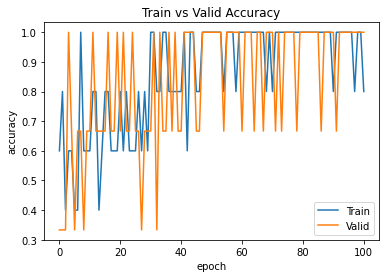

In [75]:
plt.plot(t_a)
plt.plot(v_a)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

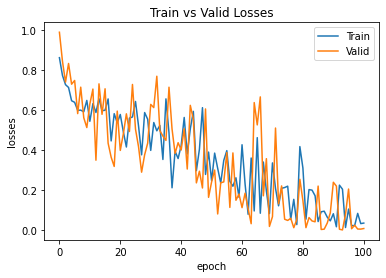

In [76]:
plt.show()

plt.plot(t_l)
plt.plot(v_l)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [77]:
#Evaluate on the test data
test_acc = test(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5000
